In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [ ]:
# def mad(dat): #median absolute deviation
#     return np.median(np.absolute(dat - np.median(dat)))

# def LMCdisk_cart(ra, dec):
    
#     '''
#     Calculate the position of stars in the LMC disk plane with 
#     center at the LMC center in cartesian coordinates (x, y).
#     This also calculates the distance to the individual stars.
    
#     This follows van der Marel and Cioni 2001 
    
#     Input
#     - ra: right ascension of stars
#     - dec: declination of stars
    
#     Output
#     - x_m: x coordinate
#     - y_m: y coordinate
#     - dis: distance to LMC star
#     '''
#     alph0 = np.radians(82.25) #right ascension of center of LMC
#     delt0 = np.radians(-69.50) #declination of center of LMC
#     pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
#     io = np.radians(25.86) #27.81 #inclination of LMC disk
#     d0 = 49.90 #distance to center of LMC
    
#     #convert to radians
#     ra = np.radians(ra)
#     dec = np.radians(dec)
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
    
#     cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
#     srcp = -np.cos(dec)*np.sin(ra-alph0)
#     srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
#     x_m = dis*srcp
#     y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
#     return x_m, y_m, dis

# #calculate absolute mag
# def absmag(magnitude,distance):
#     '''
#     - magnitude: apparent magnitude of star
#     - distance: distance to star in kpc
#     Calculate the absolute magnitude of star
#     '''
#     absm = []
#     absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
#     absm = np.squeeze(np.array(absm))
#     return absm

# def sal(MH,aM):
#     '''
#     Calculate the Salaris correction to the overall metallicity
#     '''
#     return MH + np.log(0.638*(10**(aM))+0.362)

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

In [3]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

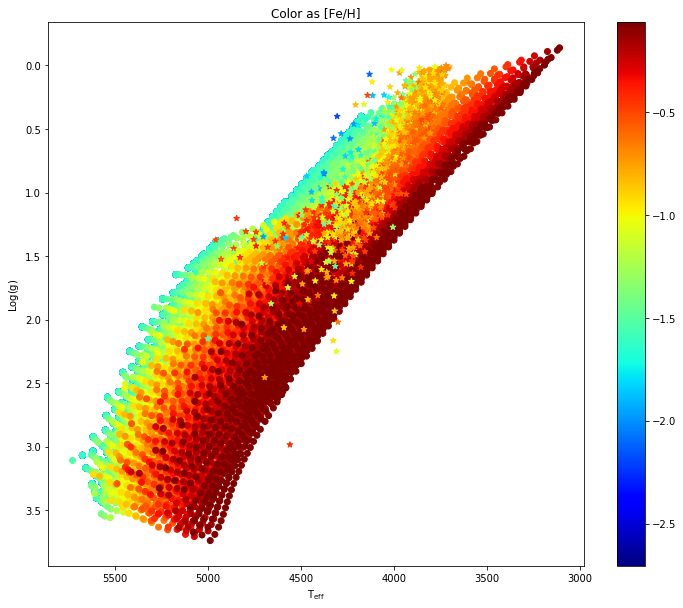

In [4]:
#####################
### Isochrone CMD ###
#####################

plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe']+75,parsec['logg'],c=np.log10(parsec['Zini']/0.02),cmap='jet')
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],vmin=np.min(np.log10(parsec['Zini']/0.02)),
            vmax=np.max(np.log10(parsec['Zini']/0.02)),cmap='jet',marker='*')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{Log(g)}$')
plt.title(r'Color as [Fe/H]')
plt.show()


Text(0.5, 1.0, 'Color as Log(g)')

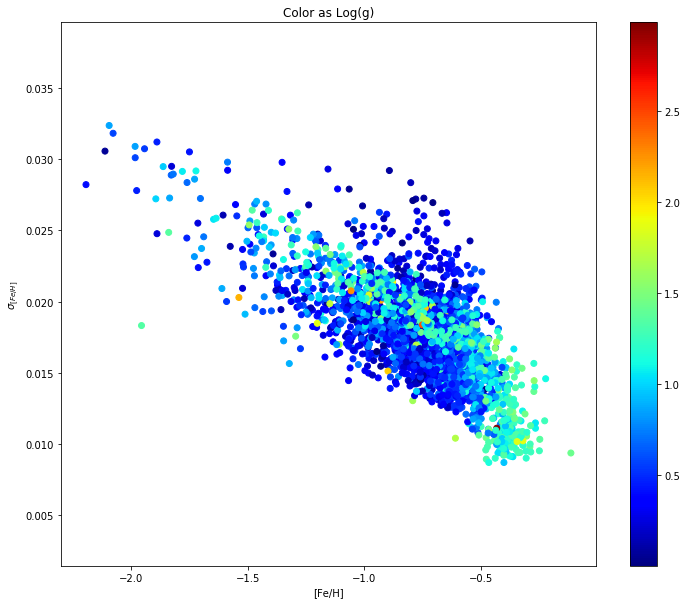

In [5]:
#########################
### Metallicity Error ###
#########################

plt.figure(figsize=[12,10])
plt.scatter(r13['FE_H'][np.where(r13['FE_H']>-9999.0)],r13['FE_H_ERR'][np.where(r13['FE_H']>-9999.0)],
            c=r13['LOGG'][np.where(r13['FE_H']>-9999.0)],cmap='jet')
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'$\sigma_{[Fe/H]}$')
plt.title(r'Color as Log(g)')

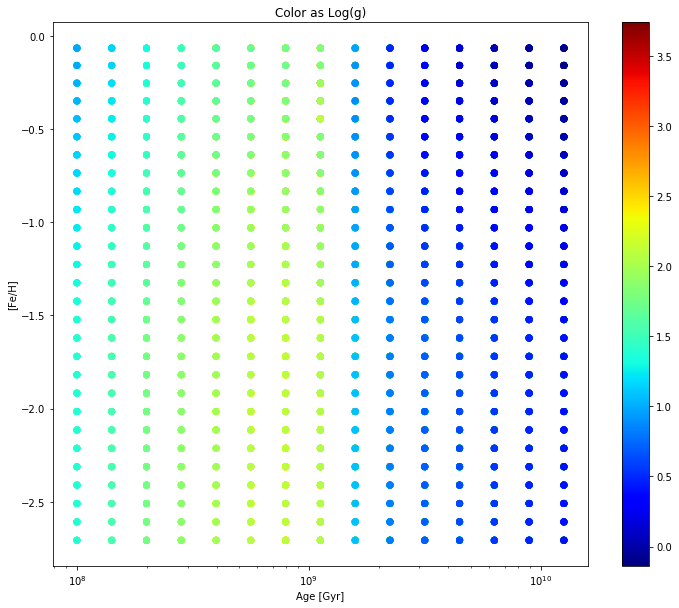

In [6]:
############################
### Age Metallicity Grid ###
############################

plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logAge'],np.log10(parsec['Zini']/0.02),c=parsec['logg'],cmap='jet')
plt.xscale('log')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
plt.colorbar()
plt.title('Color as Log(g)')
plt.show()

In [7]:
import itertools as it

lt = parsec['logTe']
k = parsec['Ksmag']
feh = np.log10(parsec['Zini']/0.02)
lg  = parsec['logg']
ltk = np.multiply(lt,k)
ltfeh = np.multiply(lt,feh)
ltlg = np.multiply(lt,lg)
kfeh = np.multiply(k,feh)
klg = np.multiply(k,lg)
fehlg = np.multiply(feh,lg)
lt2 = lt**2
k2 = k**2
feh2 = feh**2
lg2 = lg**2

models = []
models_str = []
all_var_str = ['lt','k','feh','lg','ltk','ltfeh','ltlg','kfeh','klg','fehlg','lt2','k2','feh2','lg2']
all_var = [lt,k,feh,lg,ltk,ltfeh,ltlg,kfeh,klg,fehlg,lt2,k2,feh2,lg2]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='lt' and models_str[j][1]=='k' and models_str[j][2]=='feh' and models_str[j][3]=='lg':
        idx.append(j)
        
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

In [54]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
max_resid = []
gtest = []
mads = []
lae = []
stde = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    gtest.append(2*np.sum(predictions*np.log(np.divide(predictions,parsec['logAge']))))
    mads.append(afunc.mad(residual))
    lae.append(np.sum(np.absolute(residual)))
    stde.append(model.bse)


<bound method LikelihoodModelResults.cov_params of <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x17d2a4160>>


True


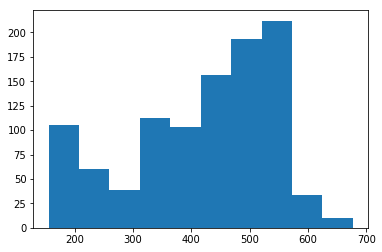

(array([992]),)


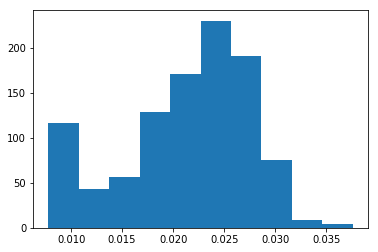

(array([992]),)


In [9]:
print(np.where(lae == min(lae)) == np.where(mads == min(mads)))

plt.hist(lae)
plt.show()
print(np.where(lae == min(lae)))
# print(models_str[992])

plt.hist(mads)
plt.show()
print(np.where(mads == min(mads)))
# print(models_str[992])

In [21]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(mads)<=0.01)

terms = []
for i in range(len(models_str[small])):
    terms.append(len(models_str[small][i]))
    
print(terms)
for j in range(7):
    print('index: ',np.arange(len(models_str))[small][j])
    print(models_str[small][j])

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
index:  506
['lt' 'k' 'feh' 'lg' 'ltk' 'klg' 'k2' 'feh2' 'lg2']
index:  606
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
index:  609
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'lt2' 'k2' 'lg2']
index:  611
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'k2' 'feh2' 'lg2']
index:  626
['lt' 'k' 'feh' 'lg' 'kfeh' 'klg' 'k2' 'feh2' 'lg2']
index:  635
['lt' 'k' 'feh' 'lg' 'klg' 'fehlg' 'k2' 'feh2' 'lg2']
index:  636
['lt' 'k' 'feh' 'lg' 'klg' 'lt2' 'k2' 'feh2' 'lg2']


In [96]:
# from scipy.optimize import curve_fit

# def model(x,const,a,b,c,d,e,f,g,h,i):
#     return const + a*x[0] + b*x[1] + c*x[2] + d*x[3] + e*np.multiply(x[0],x[3]) + f*np.multiply(x[1],x[3]) + g*np.multiply(x[2],x[3]) + h*np.square(x[1]) + i*np.square(x[3])

# popt, pcov = curve_fit(model, np.array(models[606]), parsec['logAge'])

In [10]:
print(all_params[992])
print(models_str[992])

[ 2.07483027e+01  1.25330396e+00  4.38762008e+00  3.15757396e+00
 -6.92771748e+00 -3.98506724e-01 -8.32023943e-01 -8.80250421e-03
 -5.27532676e-01  5.78640717e-02  1.16480914e-01  4.97348135e-02
  6.19034227e-01]
['lt' 'k' 'feh' 'lg' 'ltk' 'ltfeh' 'kfeh' 'klg' 'fehlg' 'k2' 'feh2' 'lg2']


In [24]:
print(np.asarray(all_params[606]))
print(np.asarray(models_str[606]))

[ 2.34865658e+01  7.73561422e-01  3.31229224e+00 -3.92253575e-02
 -4.71932940e+00 -8.67142123e-01 -6.83193259e-01  1.93831669e-02
  1.39372987e-01  8.31208860e-01]
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']


In [13]:
# parsimonious = np.array([lt,k,feh,lg,ltk,ltfeh,kfeh,klg,fehlg,k2,feh2,lg2]).T
# parsimonious = sm.add_constant(parsimonious)
# parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
# parsimonious_predictions = parsimonious_model.predict(parsimonious)
# parsimonious_residual = parsimonious_predictions - parsec['logAge']
# parsimonious_summary = parsimonious_model.summary()
# print(parsimonious_summary)
# print(np.asarray(parsimonious_model.params))

In [25]:
def find_age(lt,k,feh,lg):
    #['lt' 'k' 'feh' 'lg' 'ltk' 'ltfeh' 'kfeh' 'klg' 'fehlg' 'k2' 'feh2' 'lg2']
#     p = [2.07483027e+01,1.25330396e+00,4.38762008e+00,3.15757396e+00,-6.92771748e+00,-3.98506724e-01,-8.32023943e-01,-8.80250421e-03,-5.27532676e-01,5.78640717e-02,1.16480914e-01,4.97348135e-02,6.19034227e-01]
#     age = p[0] + p[1]*lt + p[2]*k + p[3]*feh + p[4]*lg + p[5]*np.multiply(lt,k) + p[6]*np.multiply(lt,feh) + p[7]*np.multiply(k,feh) + p[8]*np.multiply(k,lg) + p[9]*np.multiply(feh,lg) + p[10]*np.square(k) + p[11]*np.square(feh) + p[12]*np.square(lg) 
#     return age
    #['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
    p = [2.34865658e+01,7.73561422e-01,3.31229224e+00,-3.92253575e-02,-4.71932940e+00,
         -8.67142123e-01,-6.83193259e-01,1.93831669e-02,1.39372987e-01,8.31208860e-01]
    age = p[0] + p[1]*lt + p[2]*k + p[3]*feh + p[4]*lg + p[5]*np.multiply(lt,lg) + p[6]*np.multiply(k,lg) + p[7]*np.multiply(feh,lg) + p[8]*np.square(k) + p[9]*np.square(lg)
    return age

In [26]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']
parage = find_age(np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG'])
# parage = find_age(np.log10(r13['TEFF']),corabsK,r13['LOGG']) #,sal(r13['M_H'],r13['ALPHA_M'])


In [95]:
# jacobians = []

# for i in range(len(r13)):
#     lt = np.log10(r13['TEFF'])
#     k = corabsK
#     feh = afunc.sal(r13['M_H'],metscorr)
#     lg = r13['LOGG']
#     jacobians.append(np.array([1,lt,k,feh,lg,np.multiply(lt,lg),np.multiply(k,lg),np.multiply(feh,lg),np.square(k),np.square(lg)]))

# np.dot(jacobians[0],np.dot(pcov,jacobians[0]))

# # np.shape(pcov)
# # print(pcov)

array([3.42581424e-07, 5.60198349e-07, 7.15551647e-07, ...,
       5.73226435e-07, 1.46906354e-07, 6.67582911e-08])

(array([5.30e+01, 1.57e+02, 2.22e+02, 6.38e+02, 1.08e+03, 4.11e+02,
        2.10e+01, 5.00e+00, 0.00e+00, 1.00e+00]),
 array([ 7.18225512,  7.81983576,  8.45741639,  9.09499703,  9.73257767,
        10.3701583 , 11.00773894, 11.64531958, 12.28290021, 12.92048085,
        13.55806149]),
 <a list of 10 Patch objects>)

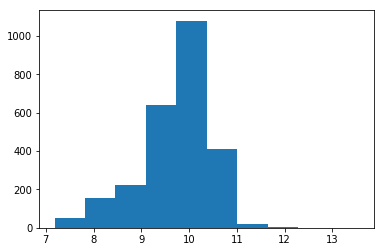

In [27]:
plt.hist(parage)

## Random Error

In [28]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [29]:
#######################################
### Get Uncertainties: Random Error ###
#######################################

randdevs = []

for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=False):
    lgT = np.log10(r13['TEFF'][i])
    lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
    ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
    mhERR = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfeERR = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
    lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(find_age(nlgT,nks,afunc.sal(nmh,nfac),nlgg))
    
    randdevs.append(afunc.mad(ages))

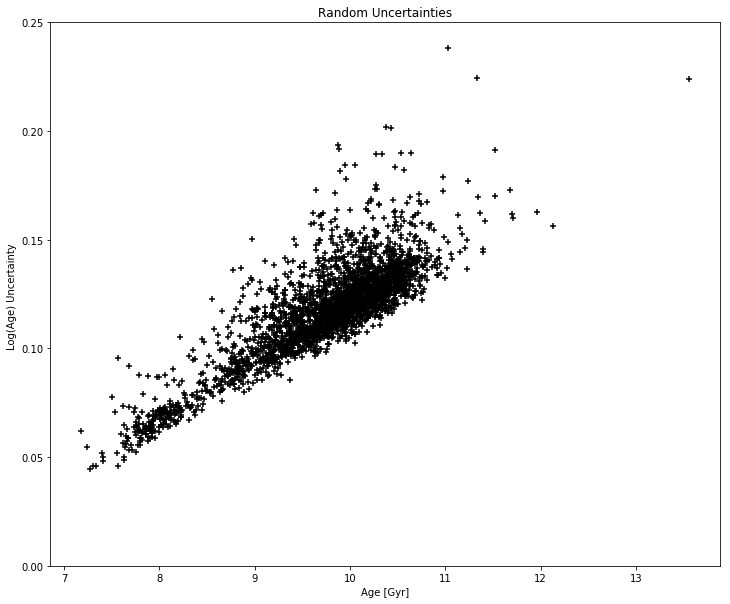

In [33]:
plt.figure(figsize=[12,10])
plt.scatter(np.asarray(parage),randdevs,marker='+',color='k')
# plt.xscale('log')
plt.ylim(0,0.25)
plt.title(r'Random Uncertainties')
plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

In [42]:
#####################################
### Get Uncertainties: Systematic ###
#####################################

#['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
def noisyparams(params,params_err):
    const_noise = np.random.normal(0,params_err[0])
    lt_noise = np.random.normal(0,params_err[1])
    k_noise = np.random.normal(0,params_err[2])
    feh_noise = np.random.normal(0,params_err[3])
    lg_noise = np.random.normal(0,params_err[4])
    
    ltlg_noise = np.random.normal(0,params_err[5])
    klg_noise = np.random.normal(0,params_err[6])
    fehlg_noise = np.random.normal(0,params_err[7])
    
    k2_noise = np.random.normal(0,params_err[8])
    lg2_noise = np.random.normal(0,params_err[9])
    
    constnew = params[0] + ((-1)**np.random.randint(2))*const_noise
    ltnew = params[1] + ((-1)**np.random.randint(2))*const_noise
    knew = params[2] + ((-1)**np.random.randint(2))*const_noise
    fehnew = params[3] + ((-1)**np.random.randint(2))*const_noise
    lgnew = params[4] + ((-1)**np.random.randint(2))*const_noise
    
    ltlgnew = params[5] + ((-1)**np.random.randint(2))*const_noise
    klgnew = params[6] + ((-1)**np.random.randint(2))*const_noise
    fehlgnew = params[7] + ((-1)**np.random.randint(2))*const_noise
    
    k2new = params[8] + ((-1)**np.random.randint(2))*const_noise
    lg2new = params[9] + ((-1)**np.random.randint(2))*const_noise
    
    newparams = [constnew,ltnew,knew,fehnew,lgnew,ltlgnew,klgnew,fehlgnew,k2new,lg2new]
    
    return newparams

def sys_find_age(lt,k,feh,lg,params):
    #['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
    age = params[0] + params[1]*lt + params[2]*k + params[3]*feh + params[4]*lg + params[5]*np.multiply(lt,lg) + params[6]*np.multiply(k,lg) + params[7]*np.multiply(feh,lg) + params[8]*np.square(k) + params[9]*np.square(lg)
    return age
    

In [45]:
#####################################
### Get Uncertainties: Systematic ###
#####################################

sysdevs = []

for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=False):
    lgT = np.log10(r13['TEFF'][i])
#     lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
#     ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
#     mhERR = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfeERR = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
#     fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
#     lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        newthings = noisyparams(all_params[606],stde[606])
        ages.append(sys_find_age(lgT,ks,afunc.sal(mh,metscorr),lgg,newthings))
    
    sysdevs.append(afunc.mad(ages))

In [48]:
print(stde[606])

[0.11950369 0.03312547 0.00826747 0.00112454 0.05497575 0.01591917
 0.00262797 0.0005067  0.00049528 0.00377418]


(array([ 34.,  66., 100., 160., 251., 348., 656., 727., 211.,  35.]),
 array([0.97727776, 1.2447494 , 1.5122211 , 1.7796929 , 2.0471644 ,
        2.3146362 , 2.582108  , 2.8495796 , 3.1170514 , 3.384523  ,
        3.6519947 ], dtype=float32),
 <a list of 10 Patch objects>)

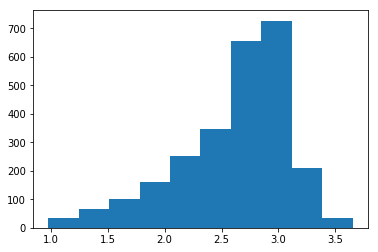

In [46]:
plt.hist(sysdevs)

In [ ]:
plt.hist(parage,range(0,15))
plt.axvline(10.13+np.median(devs),c='r')

In [ ]:
len(np.squeeze(np.where(parage>=10.13+np.median(devs))))/len(parage)

In [ ]:
plt.scatter(r13['M_H'] + np.log(0.638*(10**(r13['ALPHA_M']))+0.362),sal(r13['M_H'],metscorr))
plt.plot([-3,-2,-1,0,1],[-3,-2,-1,0,1],c='k')

In [ ]:
plt.hist(10**parsec['logAge'])
plt.xscale('log')

In [57]:
len(all_params[606])

10

(array([  1.,   1.,   5.,   8.,  49., 266., 315., 509., 916., 518.]),
 array([0.17291006, 0.1987787 , 0.22464733, 0.25051597, 0.2763846 ,
        0.30225324, 0.32812187, 0.35399051, 0.37985915, 0.40572778,
        0.43159642]),
 <a list of 10 Patch objects>)

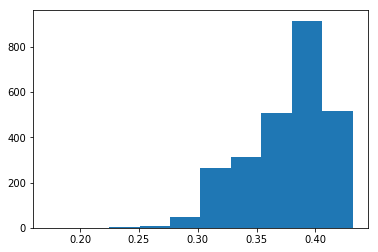

In [98]:
df_dlt = all_params[606][1] + all_params[606][5]*r13['LOGG']
df_dk = all_params[606][2] + 2*all_params[606][8]*corabsK
df_dfeh = all_params[606][3] + all_params[606][7]*r13['LOGG']
df_dlg = all_params[606][4] + all_params[606][7]*afunc.sal(r13['M_H'],metscorr) + 2*all_params[606][9]*r13['LOGG'] + all_params[606][5]*np.log10(r13['TEFF'])

variance = np.multiply(df_dlt**2,stde[606][1]**2) + np.multiply(df_dk**2,stde[606][2]**2) + np.multiply(df_dfeh**2,stde[606][3]**2) + np.multiply(df_dlg**2,stde[606][4]**2)


plt.hist(np.sqrt(variance))

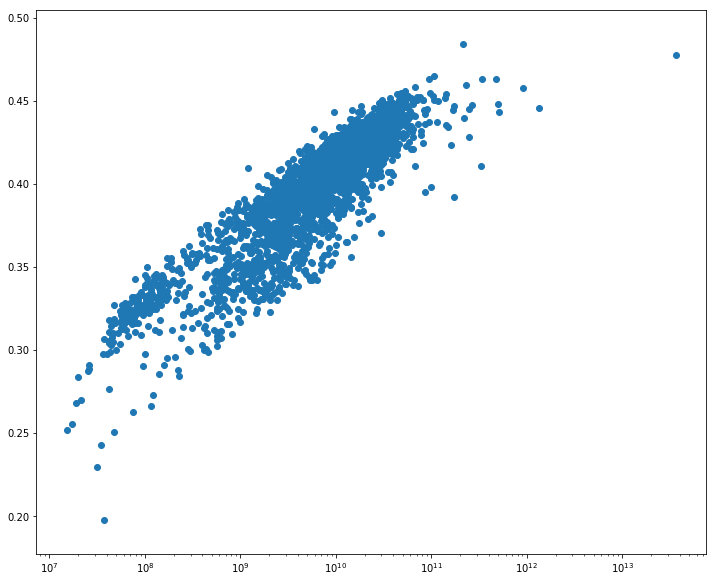

In [69]:
plt.figure(figsize=[12,10])
plt.scatter(10**parage,np.sqrt(variance+np.square(randdevs)))
plt.xscale('log')

In [66]:
np.median(np.sqrt(variance+np.square(randdevs)))

len(np.squeeze(np.where(parage>=10.13+np.median(np.sqrt(variance+np.square(randdevs))))))/len(parage)

0.08809891808346214

## Grid interpolator

In [ ]:
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator, LinearNDInterpolator


In [ ]:
X = np.array([y1,y2,y3,y4]).T
y = parsec['logAge']

myInterpolator = LinearNDInterpolator(X, y)

In [ ]:
lt = np.log10(r13['TEFF'])
k = corabsK
feh = sal(r13['M_H'],np.squeeze(metscorr))
lg = r13['LOGG']

ages = []
for i in range(len(r13)):
    ages.append(myInterpolator(lt[i],k[i],feh[i],lg[i]))

In [ ]:
plt.hist(10**np.asarray(ages)/10**9)

In [ ]:
np.nanmax(10**np.asarray(ages)/10**9)

In [ ]:
print(np.squeeze(np.where(np.isfinite(10**np.asarray(ages)/10**9)==False)).data)